In [1]:
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib as plt
import numpy as np
from sklearn.metrics import confusion_matrix,recall_score, precision_score, f1_score, fbeta_score, accuracy_score
import seaborn as sns

campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank_holdout_test.csv')
campaign

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37064,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
37065,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
37066,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
37067,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [2]:
campaign = campaign.dropna().copy()

# Make categorical features
campaign['nr.employed_cat'] = campaign['nr.employed'].astype('category')
campaign['cons.price.idx_cat'] = campaign['cons.price.idx'].astype('category')
campaign['emp.var.rate_cat'] = campaign['emp.var.rate'].astype('category')

In [3]:
campaign = campaign.dropna().copy()

# Make categorical features
holdout['nr.employed_cat'] = holdout['nr.employed'].astype('category')
holdout['cons.price.idx_cat'] = holdout['cons.price.idx'].astype('category')
holdout['emp.var.rate_cat'] = holdout['emp.var.rate'].astype('category')

In [4]:
# Binning pdays column
def days_to_weeks(days):
      if days == 999:
        return -1
      else:
        return days // 7 + (1 if days % 7 > 0 else 0)

holdout['weeks'] = holdout['pdays'].apply(lambda x: days_to_weeks(x))
holdout['weeks'] = holdout['weeks'].astype('category')

# Define the boundaries for the age bins
age_bins = [0, 35, 55, float('inf')]  # Define bins as (0-35], (35-55], (55 and above]
# Define labels for the bins
age_labels = ['young adult', 'middle-aged', 'senior']
# Create a new column 'age_group' with the bin labels
holdout['age_group'] = pd.cut(holdout['age'], bins=age_bins, labels=age_labels, right=False)
# Display the first few rows of the DataFrame with the new age_group column
holdout[['age', 'age_group']].head()
holdout.value_counts(holdout['age_group'])

age_group
middle-aged    2223
young adult    1471
senior          425
Name: count, dtype: int64

In [5]:
# Binning pdays column
def days_to_weeks(days):
      if days == 999:
        return -1
      else:
        return days // 7 + (1 if days % 7 > 0 else 0)

campaign['weeks'] = campaign['pdays'].apply(lambda x: days_to_weeks(x))
campaign['weeks'] = campaign['weeks'].astype('category')

# Define the boundaries for the age bins
age_bins = [0, 35, 55, float('inf')]  # Define bins as (0-35], (35-55], (55 and above]
# Define labels for the bins
age_labels = ['young adult', 'middle-aged', 'senior']
# Create a new column 'age_group' with the bin labels
campaign['age_group'] = pd.cut(campaign['age'], bins=age_bins, labels=age_labels, right=False)
# Display the first few rows of the DataFrame with the new age_group column
campaign[['age', 'age_group']].head()
campaign.value_counts(campaign['age_group'])

age_group
middle-aged    19981
young adult    13283
senior          3805
Name: count, dtype: int64

In [6]:
# Create feature lists
best_features = ['weeks', 'nr.employed_cat', 'cons.price.idx_cat', 'emp.var.rate_cat', 'cons.conf.idx']

<Axes: >

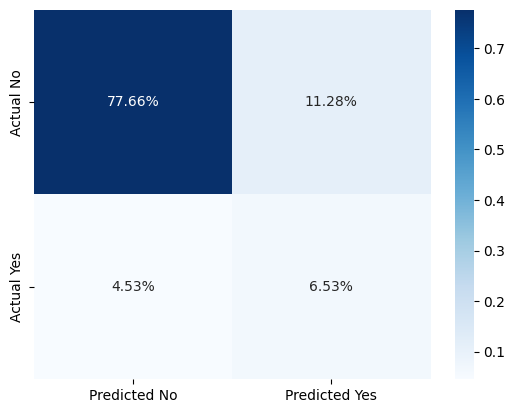

In [7]:
X = pd.get_dummies(campaign[best_features], drop_first=True)
X_holdout = pd.get_dummies(holdout[best_features], drop_first=True)

# X = campaign[best_features]
y = campaign['y']

# Split our data into training and test data, with 30% reserved for testing
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.30, random_state = 42)  # 70% for training data

X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.50, random_state = 42)  # 15% for testing and validation test
# with random_state 42, we make 11,450.54
# They lose 16,034.38 if they stayed the same
# (4960*0.75*.012 * True/Yes) + ((0.5*-11) * True/Yes) + ((0.5*-11) * False/Yes)
# Most possible is 164,701


# Create class counts and samples for use in class weights
class_counts = campaign['y'].value_counts()
total_samples = class_counts.sum()
# Calculate the class weight for the majority class (no)
class_weight_0 = total_samples / (2 * class_counts[0])
class_weight_1 = total_samples / (2 * class_counts[1]) * 0.628 # Increase the weight for class (yes)
# Create a dictionary of class weights
class_weights = {'no': class_weight_0, 'yes': class_weight_1}
# Build the decision tree
clf = DecisionTreeClassifier(random_state=42, class_weight=class_weights, max_depth=5, min_samples_leaf=10)

# Train it
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

# Add the confusion matrix
test_predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, test_predictions)

# Plot confusion matrix as a heatmap
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])

In [8]:
y.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

<Axes: >

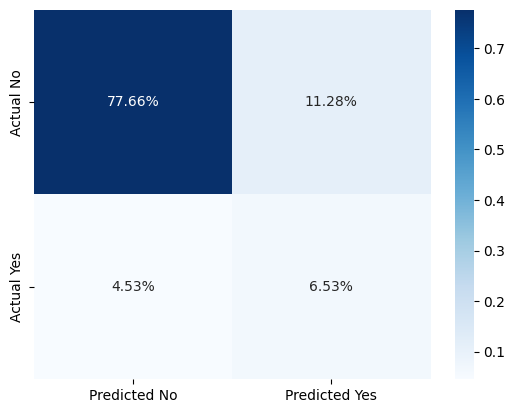

In [9]:
# Validation
clf.score(X_test, y_test)
# Add the confusion matrix
predictions = clf.predict(X_test)

holdout_predictions = clf.predict(X_holdout)

dt_cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix as a heatmap
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])

In [10]:
predictions

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [11]:
#Format and Export data
predictions_table = pd.DataFrame(holdout_predictions,columns=['predictions'])
predictions_table = predictions_table['predictions'].map({'yes': 1,'no': 0})
predictions_table.to_csv('team5-module2-predictions.csv',index=False)
predictions_table.value_counts()

predictions
0    3407
1     712
Name: count, dtype: int64

In [12]:
# rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10, class_weight=class_weights)

# rf.fit(X_train, y_train)


# # Add the confusion matrix
# rf_test_predictions = rf.predict(X_test)
# rf_cm = confusion_matrix(y_test, rf_test_predictions)

# # Plot confusion matrix as a heatmap
# sns.heatmap(rf_cm/np.sum(rf_cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])

# Value of Calls

The following is for seeing the money that would be earned based off of our models predictions.

In [13]:
def value_of_calls(incorrect_calls, correct_calls):
  '''
  This function is based on assumptions about bank employee wages, time requirements,
  average savings amounts, and net interest margin. Wages, average savings, and net interest margin,
  were pulled from the time range of the dataset. Assumptions were made about time on call and the
  percentage of a person's total savings they'd be willing to put into a term deposit.
  '''
  time_on_call = .5
  wage = -11 # minimum wage is 6.50 and typicall teller wage is 11
  call_cost = wage*time_on_call
  average_savings = 4960
  percent_in_term_deposit = .75
  net_interest_margin = .012
  positive_call_benefit = average_savings*percent_in_term_deposit*net_interest_margin
  total_earned = incorrect_calls*call_cost + correct_calls*call_cost + correct_calls*positive_call_benefit
  return total_earned

amount_earned = value_of_calls(dt_cm[0, 1], dt_cm[1, 1])

print('Total amount earned using model:')
print(f'${amount_earned:.2f}')
# print((4960*0.75*.012 * cm[1, 1]) + ((0.5*-11) * cm[1, 1]) + ((0.5*-11) * cm[0, 1]))

Total amount earned using model:
$10759.32


In [14]:
# Calculate scores for Random Forest Model

# rf_recall = recall_score(y_test, rf_test_predictions, pos_label = 'yes')
# rf_precision = precision_score(y_test, rf_test_predictions, pos_label = 'yes')
# rf_f1 = f1_score(y_test, rf_test_predictions, pos_label = 'yes')
# rf_accuracy = accuracy_score(y_test, rf_test_predictions)

# recall: Of the people that wouild have said yes, how many did I call.
# precision: Of the people that I did call, how many said yes.

# Random Forest Predicions
# print(f'recall: {(rf_recall * 100):.2f}%')
# print(f'precision: {(rf_precision * 100):.2f}%')
# print(f'f1 score: {(rf_f1 * 100):.2f}%')
# print(f'accuracy: {(rf_accuracy * 100):.2f}%')


In [15]:
# Calculate scores for Decsion Tree Model.

dt_recall = recall_score(y_test, test_predictions, pos_label = 'yes')
dt_precision = precision_score(y_test, test_predictions, pos_label = 'yes')
dt_f1 = f1_score(y_test, test_predictions, pos_label = 'yes')
dt_accuracy = accuracy_score(y_test, test_predictions)



# recall: Of the people that wouild have said yes, how many did I call.
# precision: Of the people that I did call, how many said yes.

# Decision Tree Predicions
print(f'recall: {(dt_recall * 100):.2f}%')
print(f'precision: {(dt_precision * 100):.2f}%')
print(f'f1 score: {(dt_f1 * 100):.2f}%')
print(f'accuracy: {(dt_accuracy * 100):.2f}%')


recall: 59.02%
precision: 36.67%
f1 score: 45.23%
accuracy: 84.19%
